In [14]:
from ocr.conus404 import (
    build_fire_weather_mask,
    compute_modal_wind_direction,
    compute_relative_humidity,
    compute_wind_speed_and_direction,
    geo_sel,
    load_conus404,
    rotate_winds_to_earth,
)

In [3]:
ds = load_conus404(add_spatial_constants=True)

In [9]:
ds = geo_sel(ds, bbox=(-123, 41, -123.1, 41.1))
ds

<xarray.Dataset> Size: 112MB
Dimensions:   (time: 376945, y: 4, x: 3)
Coordinates:
  * x         (x) float64 24B -2.052e+06 -2.048e+06 -2.044e+06
  * time      (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y         (y) float64 32B 5e+05 5.04e+05 5.08e+05 5.12e+05
    crs       int64 8B ...
    lat       (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
    lon       (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
Data variables:
    PSFC      (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    Q2        (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    T2        (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    TD2       (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    U10       (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    V10       (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    SINALPHA  (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
    COSALPHA  (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [10]:
hurs = compute_relative_humidity(ds)
earth_u, earth_v = rotate_winds_to_earth(ds)
wind_ds = compute_wind_speed_and_direction(earth_u, earth_v)

hurs_threshold = 15
wind_threshold = 35
fire_weather_mask = build_fire_weather_mask(
    hurs,
    wind_ds,
    hurs_threshold=hurs_threshold,
    wind_threshold=wind_threshold,
)

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


In [11]:
wind_ds

<xarray.Dataset> Size: 39MB
Dimensions:         (x: 3, time: 376945, y: 4)
Coordinates:
  * x               (x) float64 24B -2.052e+06 -2.048e+06 -2.044e+06
  * time            (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y               (y) float64 32B 5e+05 5.04e+05 5.08e+05 5.12e+05
    crs             int64 8B 1
    lat             (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
    lon             (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
Data variables:
    sfcWind         (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
    sfcWindfromdir  (time, y, x) float32 18MB dask.array<chunksize=(376945, 4, 3), meta=np.ndarray>
Attributes:
    units:          m s-1
    cell_methods:   
    history:        uas: \nvas: \n[2025-09-04 16:29:07] sfcWind: WIND_SPEED_F...
    standard_name:  wind_speed
    long_name:      Near-surface wind speed
    description:    Wind speed computed as the magnitude of the (uas, vas) ve...

In [12]:
mode = compute_modal_wind_direction(wind_ds['sfcWindfromdir'], fire_weather_mask)
mode

<xarray.Dataset> Size: 256B
Dimensions:              (x: 3, y: 4)
Coordinates:
  * x                    (x) float64 24B -2.052e+06 -2.048e+06 -2.044e+06
  * y                    (y) float64 32B 5e+05 5.04e+05 5.08e+05 5.12e+05
    crs                  int64 8B 1
    lat                  (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
    lon                  (y, x) float32 48B dask.array<chunksize=(4, 3), meta=np.ndarray>
Data variables:
    wind_direction_mode  (y, x) float64 96B dask.array<chunksize=(4, 3), meta=np.ndarray>

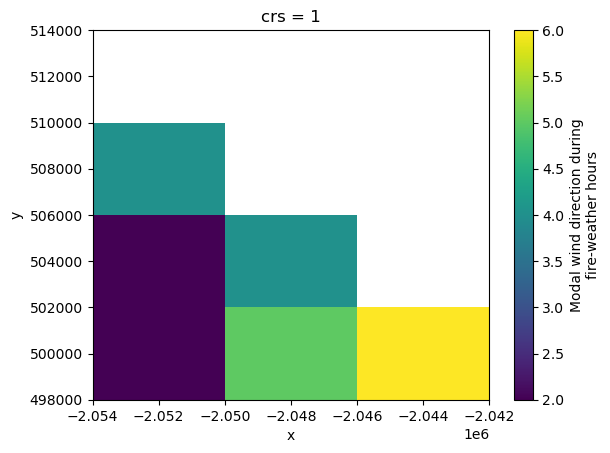

In [13]:
mode.wind_direction_mode.plot()